In [13]:
# Adversarial Neural Cryptography - https://arxiv.org/pdf/1610.06918.pdf

In [14]:
# Necessary imports
import torch
import random

import numpy as np
from torch import nn

import matplotlib.pyplot as plt

In [15]:
# Define the length of the key and the message
pln_txt_len = sec_key_len = cip_txt_len = 16

In [16]:
# Function to generate a random plain text and a secret key
def create_batch(plain_text_len, secret_key_len, batch_size):
    plain_text = torch.zeros(batch_size, plain_text_len)
    secret_key = torch.zeros(batch_size, secret_key_len)
    
    for i in range(batch_size):
        for j in range(plain_text_len):
            plain_text[i][j] = random.randint(0, 1)
        for j in range(secret_key_len):
            secret_key[i][j] = random.randint(0, 1)
            
    return plain_text.float(), secret_key.float()

plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 256)
print(plain_text.shape, secret_key.shape)

torch.Size([256, 16]) torch.Size([256, 16])


In [17]:
# Alice's network

class Alice_Net(nn.Module):
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len):
        super(Alice_Net, self).__init__()
        self.input_size  = plain_text_len + secret_key_len
        self.output_size = cipher_text_len
        
        self.W = nn.Sequential(
            nn.Linear(self.input_size, self.input_size),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Sigmoid(),      
        )
        
    def forward(self, plain_text, secret_key):
        x = torch.cat((plain_text, secret_key), axis=-1)
        x = torch.unsqueeze(x, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = x.view(-1, self.output_size)
        return x
    
    def encrypt(self, plain_text, secret_key):
        encrypted_text = self.forward(plain_text, secret_key)
        return torch.as_tensor((encrypted_text - 0.5) > 0, dtype=torch.float32)

In [18]:
# Bob's network

class Bob_Net(nn.Module):
    def __init__(self, plain_text_len, secret_key_len, cipher_text_len):
        super(Bob_Net, self).__init__()
        self.input_size  = cipher_text_len + secret_key_len
        self.output_size = plain_text_len
        
        self.W = nn.Sequential(
            nn.Linear(self.input_size, self.input_size),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Sigmoid(),      
        )
        
    def forward(self, cipher_text, secret_key):
        x = torch.cat((cipher_text, secret_key), axis=-1)
        x = torch.unsqueeze(x, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = x.view(-1, self.output_size)
        return x
    
    def decrypt(self, cipher_text, secret_key):
        decrypted_text = self.forward(cipher_text, secret_key)
        return torch.as_tensor((decrypted_text - 0.5) > 0, dtype=torch.float32)

In [19]:
# Eve's network

class Eve_Net(nn.Module):
    def __init__(self, plain_text_len, cipher_text_len):
        super(Eve_Net, self).__init__()
        self.input_size  = cipher_text_len
        self.output_size = plain_text_len
        
        self.W = nn.Sequential(
            nn.Linear(self.input_size, 2 * self.input_size),
            nn.Tanh(),
        )
        
        self.C = nn.Sequential(
            nn.Conv1d(1, 2, 4, stride=1, padding=2),
            nn.Tanh(),  
            nn.Conv1d(2, 4, 2, stride=2, padding=0),
            nn.Tanh(), 
            nn.Conv1d(4, 4, 1, stride=1, padding=0),
            nn.Tanh(),   
            nn.Conv1d(4, 1, 1, stride=1, padding=0),
            nn.Sigmoid(),      
        )
        
    def forward(self, cipher_text):
        x = torch.unsqueeze(cipher_text, 1)
        
        x = self.W(x)
        x = self.C(x)
        
        x = x.view(-1, self.output_size)
        return x
    
    def eavesdrop(self, cipher_text):
        eavesdrop_text = self.forward(cipher_text)
        return torch.as_tensor((eavesdrop_text - 0.5) > 0, dtype=torch.float32)

In [20]:
# Define the device

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(torch.cuda.get_device_name(torch.cuda.current_device()))

NVIDIA GeForce RTX 2070 Super with Max-Q Design


In [21]:
# Instantiate the models
Alice = Alice_Net(pln_txt_len, sec_key_len, cip_txt_len).to(device)
Bob   = Bob_Net(pln_txt_len, sec_key_len, cip_txt_len).to(device)
Eve   = Eve_Net(pln_txt_len, cip_txt_len).to(device)

print("All models instantiated successfully !!!")

All models instantiated successfully !!!


In [22]:
# Hyperparameters
n_epochs   = 100
eve_edge   = 2

train_size = 2 ** 12
batch_size = 128

# Define the optimizers
lr = 0.0008

optim_Alice = torch.optim.Adam(Alice.parameters(), lr=lr)
optim_Bob   = torch.optim.Adam(Bob.parameters(), lr=lr)
optim_Eve   = torch.optim.Adam(Eve.parameters(), lr=lr)

optimizers  = [optim_Alice, optim_Bob, optim_Eve]

In [23]:
# Custom Loss functions
criterion = nn.L1Loss()

class AliceBobLoss(nn.Module):
    def __init__(self, sec_key_len):
        super(AliceBobLoss, self).__init__()
        self.N = sec_key_len
    
    def forward(self, plain_text, decrypted_text, alice_eve_loss):
        loss = torch.mean(torch.sum(torch.abs(plain_text - decrypted_text), axis=-1))
        loss += (((self.N / 2) - alice_eve_loss)**2 / (self.N / 2)**2)
        return loss
    
class AliceEveLoss(nn.Module):
    def __init__(self):
        super(AliceEveLoss, self).__init__()
    
    def forward(self, plain_text, eavesdrop_text):
        return torch.mean(torch.sum(torch.abs(plain_text - eavesdrop_text), axis=-1))
    
criterion_AliceBob = AliceBobLoss(sec_key_len)
criterion_AliceEve = AliceEveLoss()
criterions = [criterion_AliceBob, criterion_AliceEve]

def hamming_distance(x, y):
    return torch.mean(torch.sum(torch.abs(x - y), axis=-1))

In [24]:
# Train the networks
# Eve is trained eve_edge times for every training of Alice and Bob
alice_bob_dist, alice_eve_dist = np.zeros(n_epochs * (train_size // batch_size)), np.zeros(n_epochs * (train_size // batch_size))

def train(Alice, Bob, Eve, criterions, optimizers, train_size=10000, eve_edge=2, n_epochs=100, batch_size=256):
    print("Training started ...")
    
    # Initialize the losses
    n_batches = train_size // batch_size
    
    for epoch in range(n_epochs):
        bob_dist, eve_dist = np.zeros(n_batches), np.zeros(n_batches)

        for batch in range(n_batches):  
            # for _ in range(1):      
            plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
            plain_text, secret_key = plain_text.to(device), secret_key.to(device)
        
            optimizers[0].zero_grad()
            optimizers[1].zero_grad()
            
            # Train Alice and Bob        
            encrypted_text = Alice(plain_text, secret_key)
            decrypted_text = Bob(encrypted_text, secret_key)
            eavesdrop_text = Eve(encrypted_text)

            # Expectation of the loss
            alice_eve_loss = criterions[1](plain_text, eavesdrop_text)
            bob_loss = criterions[0](plain_text, decrypted_text, alice_eve_loss)
            loss_bob = criterions[1](plain_text, decrypted_text).item()
            
            # Back-propagation
            bob_loss.backward()
            
            optimizers[0].step()
            optimizers[1].step()

            # Train Eve
            loss_eve = 0
            for _ in range(eve_edge):
                plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
                plain_text, secret_key = plain_text.to(device), secret_key.to(device)
                
                optimizers[2].zero_grad() 
                
                # Detach the encrypted text from the graph to prevent backpropagation
                encrypted_text = Alice(plain_text, secret_key)
                eavesdrop_text = Eve(encrypted_text)
            
                # Expectation of the loss 
                eve_loss = criterions[1](plain_text, eavesdrop_text)
                loss_eve += eve_loss.item()
                
                # Back-propagation                    
                eve_loss.backward()
                
                optimizers[2].step()
            loss_eve /= eve_edge * 1.0
                
            alice_bob_dist[epoch * n_batches + batch] = bob_dist[batch] = loss_bob
            alice_eve_dist[epoch * n_batches + batch] = eve_dist[batch] = loss_eve
                
            print("\rEpoch: {}/{} | Batch: {}/{} | Bob: {:.4f} | Eve: {:.4f}".format(epoch+1, n_epochs, batch+1, n_batches, bob_loss, eve_loss), end="", flush=True)
              
        print("\rEpoch: {}/{} | Average number of bits wrong (of {}) Bob: {} , Eve: {}".format(epoch+1, n_epochs, sec_key_len, np.round(np.mean(bob_dist), 4), np.round(np.mean(eve_dist), 4)), end='\n', flush=True)
    
    print("\rTraining completed !!!")
    
# Set the models to train mode
Alice.train()
Bob.train()
Eve.train()

train(Alice, Bob, Eve, criterions, optimizers, train_size, eve_edge, n_epochs, batch_size)

Training started ...
Epoch: 1/100 | Average number of bits wrong (of 16) Bob: 7.9995 , Eve: 8.0005
Epoch: 2/100 | Average number of bits wrong (of 16) Bob: 8.0006 , Eve: 7.9977
Epoch: 3/100 | Average number of bits wrong (of 16) Bob: 7.9986 , Eve: 8.0067
Epoch: 4/100 | Average number of bits wrong (of 16) Bob: 7.9984 , Eve: 7.9987
Epoch: 5/100 | Average number of bits wrong (of 16) Bob: 7.9916 , Eve: 8.0032
Epoch: 6/100 | Average number of bits wrong (of 16) Bob: 7.9679 , Eve: 7.9969
Epoch: 7/100 | Average number of bits wrong (of 16) Bob: 7.7916 , Eve: 7.8621
Epoch: 8/100 | Average number of bits wrong (of 16) Bob: 7.1286 , Eve: 6.5589
Epoch: 9/100 | Average number of bits wrong (of 16) Bob: 6.0834 , Eve: 4.8717
Epoch: 10/100 | Average number of bits wrong (of 16) Bob: 5.156 , Eve: 4.0236
Epoch: 11/100 | Average number of bits wrong (of 16) Bob: 4.4727 , Eve: 3.4571
Epoch: 12/100 | Average number of bits wrong (of 16) Bob: 3.9471 , Eve: 3.0134
Epoch: 13/100 | Average number of bits wr

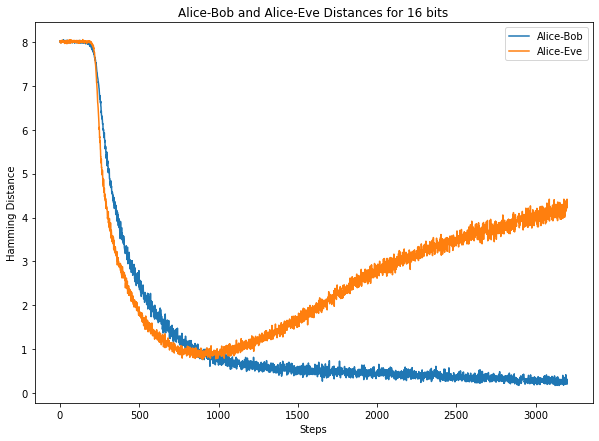

In [25]:
# Plot the results
plt.figure(figsize=(10, 7))
plt.title("Alice-Bob and Alice-Eve Distances for {} bits".format(sec_key_len))

steps = np.arange(alice_bob_dist.shape[0])
plt.plot(steps, alice_bob_dist, label="Alice-Bob")
plt.plot(steps, alice_eve_dist, label="Alice-Eve")
plt.ylabel("Hamming Distance")
plt.xlabel("Steps")

plt.legend()
plt.show()

In [1]:
# Save the models
# torch.save(Alice.state_dict(), "CNN_Alice.pth")
# torch.save(Bob.state_dict(), "CNN_Bob.pth")
# torch.save(Eve.state_dict(), "CNN_Eve.pth")

print("Models saved successfully !!!")

Models saved successfully !!!


In [26]:
# Freeze Alice and Bob but not Eve
alice_bob_dist, alice_eve_dist = np.zeros(n_epochs * (train_size // batch_size)), np.zeros(n_epochs * (train_size // batch_size))

def post_train(Alice, Bob, Eve, criterions, optimizers, train_size=10000, n_epochs=100, batch_size=256):
    print("Training started ...")
    
    # Initialize the losses
    n_batches = train_size // batch_size
    
    for epoch in range(n_epochs):
        bob_dist, eve_dist = np.zeros(n_batches), np.zeros(n_batches)

        # Train only Eve
        for batch in range(n_batches):  
            plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, batch_size)
            plain_text, secret_key = plain_text.to(device), secret_key.to(device)
                
            optimizers[2].zero_grad() 
                
            # Detach the encrypted text from the graph to prevent backpropagation
            encrypted_text = Alice(plain_text, secret_key)
            decrypted_text = Bob(encrypted_text, secret_key)
            eavesdrop_text = Eve(encrypted_text)
            
            # Expectation of the loss 
            bob_loss = criterions[1](plain_text, decrypted_text)
            eve_loss = criterions[1](plain_text, eavesdrop_text)
                
            # Back-propagation                    
            eve_loss.backward()
            optimizers[2].step()
                
            alice_bob_dist[epoch * n_batches + batch] = bob_dist[batch] = bob_loss.item()
            alice_eve_dist[epoch * n_batches + batch] = eve_dist[batch] = eve_loss.item()
                
            print("\rEpoch: {}/{} | Batch: {}/{} | Bob: {:.4f} | Eve: {:.4f}".format(epoch+1, n_epochs, batch+1, n_batches, bob_loss, eve_loss), end="", flush=True)      
        print("\rEpoch: {}/{} | Average number of bits wrong (of {}) Bob: {} , Eve: {}".format(epoch+1, n_epochs, sec_key_len, np.round(np.mean(bob_dist), 4), np.round(np.mean(eve_dist), 4)), end='\n', flush=True)
    
    print("\rTraining completed !!!")
    
# Set the models to train mode
Alice.eval()
Bob.eval()
Eve.train()

post_train(Alice, Bob, Eve, criterions, optimizers, train_size, n_epochs, batch_size)

Training started ...
Epoch: 1/100 | Average number of bits wrong (of 16) Bob: 0.2696 , Eve: 4.2193
Epoch: 2/100 | Average number of bits wrong (of 16) Bob: 0.2722 , Eve: 4.2014
Epoch: 3/100 | Average number of bits wrong (of 16) Bob: 0.2687 , Eve: 4.1882
Epoch: 4/100 | Average number of bits wrong (of 16) Bob: 0.2748 , Eve: 4.1559
Epoch: 5/100 | Average number of bits wrong (of 16) Bob: 0.2698 , Eve: 4.173
Epoch: 6/100 | Average number of bits wrong (of 16) Bob: 0.2883 , Eve: 4.2041
Epoch: 7/100 | Average number of bits wrong (of 16) Bob: 0.2831 , Eve: 4.1466
Epoch: 8/100 | Average number of bits wrong (of 16) Bob: 0.2597 , Eve: 4.1565
Epoch: 9/100 | Average number of bits wrong (of 16) Bob: 0.2776 , Eve: 4.1764
Epoch: 10/100 | Average number of bits wrong (of 16) Bob: 0.265 , Eve: 4.2069
Epoch: 11/100 | Average number of bits wrong (of 16) Bob: 0.2615 , Eve: 4.1361
Epoch: 12/100 | Average number of bits wrong (of 16) Bob: 0.2631 , Eve: 4.1939
Epoch: 13/100 | Average number of bits wro

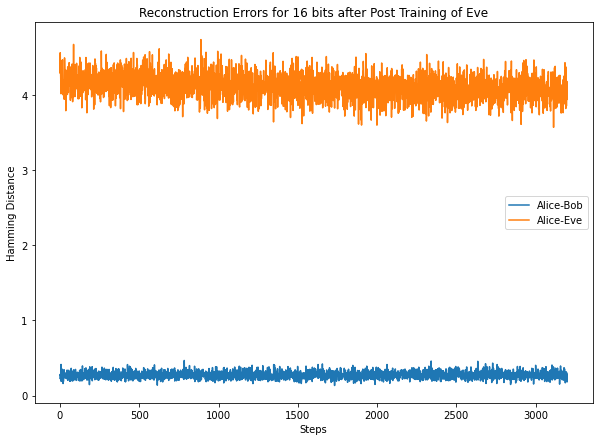

In [29]:
# Plot the results
plt.figure(figsize=(10, 7))
plt.title("Reconstruction Errors for {} bits after Post Training of Eve".format(sec_key_len))

steps = np.arange(alice_bob_dist.shape[0])
plt.plot(steps, alice_bob_dist, label="Alice-Bob")
plt.plot(steps, alice_eve_dist, label="Alice-Eve")
plt.ylabel("Hamming Distance")
plt.xlabel("Steps")

plt.legend()
plt.show()

In [49]:
# Set the models to evaluation mode
Alice.eval()
Bob.eval()
Eve.eval()

# Test the networks
plain_text, secret_key = create_batch(pln_txt_len, sec_key_len, 1)
plain_text, secret_key = plain_text.to(device), secret_key.to(device)

print("Plain text: ", plain_text.cpu().squeeze().numpy())

encrypted_text = Alice.encrypt(plain_text, secret_key)
print("Encrypted text: ", encrypted_text.detach().cpu().squeeze().numpy())
      
decrypted_text = Bob.decrypt(encrypted_text, secret_key)
print("Bob's decrypted text: {}, Distance: {:.4f}".format(decrypted_text.detach().cpu().squeeze().numpy(), criterion_AliceEve(plain_text, decrypted_text).item()))

eavesdrop_text = Eve.eavesdrop(encrypted_text)
print("Eve's eavesdrop text: {}, Distance: {:.4f}".format(eavesdrop_text.detach().cpu().squeeze().numpy(), criterion_AliceEve(plain_text, eavesdrop_text).item()))

Plain text:  [1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0.]
Encrypted text:  [1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
Bob's decrypted text: [1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.], Distance: 4.0000
Eve's eavesdrop text: [1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1.], Distance: 6.0000
